In [14]:
import pandas as pd
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt


In [15]:
def generate_train_routes(blocks_file, scheduled_file, unscheduled_file, min_duration=1):
    """
    Generate realistic train_routes dict with block sequences and durations.
    Returns: train_routes: {train_id: [(block, duration), ...], ...}
    """
    # --- Load block data ---
    df_blocks = pd.read_csv(blocks_file)  # columns: block_id, start_km, end_km
    df_blocks = df_blocks.sort_values('block_id').reset_index(drop=True)
    block_lengths = {row['block_id']: row['end_km'] - row['start_km'] for _, row in df_blocks.iterrows()}

    train_routes = {}

    # --- Scheduled trains ---
    df_s = pd.read_csv(scheduled_file)
    for train_id in df_s['train_no'].unique():
        # For demo: assign all blocks in order (replace with real halts if available)
        blocks_seq = list(df_blocks['block_id'])
        speed_kmph = float(df_s[df_s['train_no'] == train_id]['max_speed_kmph'].values[0])
        durations = [max(min_duration, int((block_lengths[b] / speed_kmph) * 60)) for b in blocks_seq]  # minutes
        train_routes[train_id] = list(zip(blocks_seq, durations))

    # --- Unscheduled trains ---
    df_u = pd.read_csv(unscheduled_file)
    for train_id in df_u['train_no'].unique():
        row = df_u[df_u['train_no'] == train_id].iloc[0]
        start_loop = row['start_loop']
        end_loop = row['end_loop']
        speed_kmph = float(row['max_speed_kmph'])
        # select blocks between start_loop and end_loop (inclusive)
        blocks_seq = df_blocks[(df_blocks['block_id'] >= start_loop) & (df_blocks['block_id'] <= end_loop)]['block_id'].tolist()
        durations = [max(min_duration, int((block_lengths[b] / speed_kmph) * 60)) for b in blocks_seq]
        train_routes[train_id] = list(zip(blocks_seq, durations))

    return train_routes

In [16]:
def compute_metrics(schedule):
    """
    schedule: list of tuples (train_id, block_id, start, end)
    Returns dict of metrics:
      - makespan (minutes)
      - throughput (trains per minute) computed as num_trains / makespan
      - num_trains
      - block_utilization: {block: busy_minutes}
      - avg_wait_per_train: avg(total waiting time per train) estimated from gaps between their blocks
    """
    if not schedule:
        return {}

    makespan = max(end for _, _, _, end in schedule)
    trains = sorted({t for t, _, _, _ in schedule})
    num_trains = len(trains)
    throughput = num_trains / makespan if makespan > 0 else float('inf')

    # block utilization
    block_util = {}
    for _, block, start, end in schedule:
        block_util.setdefault(block, 0)
        block_util[block] += (end - start)

    # waiting per train
    train_events = {}
    for t, b, s, e in schedule:
        train_events.setdefault(t, []).append((s, e))
    total_waits = []
    for t, events in train_events.items():
        events_sorted = sorted(events)
        wait = 0
        for i in range(1, len(events_sorted)):
            prev_end = events_sorted[i-1][1]
            next_start = events_sorted[i][0]
            gap = max(0, next_start - prev_end)
            wait += gap
        total_waits.append(wait)
    avg_wait_per_train = sum(total_waits) / len(total_waits) if total_waits else 0

    return {
        "makespan": makespan,
        "throughput_trains_per_min": throughput,
        "num_trains": num_trains,
        "block_utilization_minutes": block_util,
        "avg_wait_per_train_min": avg_wait_per_train
    }

In [17]:
def print_metrics(metrics, label="Schedule"):
    print(f"--- {label} metrics ---")
    print(f"Makespan (min): {metrics['makespan']:.2f}")
    print(f"Number of trains: {metrics['num_trains']}")
    print(f"Throughput (trains/min): {metrics['throughput_trains_per_min']:.4f}")
    print(f"Avg wait per train (min): {metrics['avg_wait_per_train_min']:.2f}")
    # Optionally print per-block utilization summary:
    butil = metrics['block_utilization_minutes']
    avg_util = sum(butil.values()) / len(butil) if butil else 0
    print(f"Avg block busy time (min): {avg_util:.2f}")
    print("-----------------------\n")

In [18]:
def compute_block_delays(schedule):
    """
    Compute average waiting time per block across all trains.
    Returns: {block_id: avg_wait}
    """
    block_waits = {}

    # collect usage of each train in order
    train_events = {}
    for t, b, s, e in schedule:
        train_events.setdefault(t, []).append((b, s, e))

    for t, events in train_events.items():
        events_sorted = sorted(events, key=lambda x: x[1])  # sort by start time
        for i in range(1, len(events_sorted)):
            prev_block, _, prev_end = events_sorted[i - 1]
            cur_block, cur_start, _ = events_sorted[i]
            wait = max(0, cur_start - prev_end)
            block_waits.setdefault(cur_block, []).append(wait)

    # average wait per block
    block_avg = {b: sum(v) / len(v) for b, v in block_waits.items()}
    return block_avg

In [19]:
def plot_block_delay_linegraph(naive_schedule, or_schedule):
    """
    Plot line graph of average block delays for Naive vs OR schedule.
    """
    naive_block_delays = compute_block_delays(naive_schedule)
    or_block_delays = compute_block_delays(or_schedule)

    blocks = sorted(set(naive_block_delays.keys()) | set(or_block_delays.keys()))
    naive_vals = [naive_block_delays.get(b, 0) for b in blocks]
    or_vals = [or_block_delays.get(b, 0) for b in blocks]

    plt.figure(figsize=(12, 6))
    plt.plot(blocks, naive_vals, marker="o", linestyle="-", color="red", label="Naive Avg Block Delay")
    plt.plot(blocks, or_vals, marker="s", linestyle="--", color="blue", label="OR (CP-SAT) Avg Block Delay")

    plt.xlabel("Block ID")
    plt.ylabel("Average Delay (minutes)")
    plt.title("Average Delay per Block (Naive vs OR)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [20]:
def plot_schedule(schedule, title):
    # map block -> row index (sorted by block id)
    blocks_sorted = sorted({b for _, b, _, _ in schedule})
    blocks_pos = {b: i for i, b in enumerate(blocks_sorted)}
    trains = sorted({t for t, _, _, _ in schedule})
    colors = plt.cm.get_cmap("tab20", max(1, len(trains)))
    train_color = {train: colors(i % 20) for i, train in enumerate(trains)}

    fig, ax = plt.subplots(figsize=(12, max(4, 0.5 * len(blocks_sorted))))
    for train_id, block_id, start, end in schedule:
        ax.barh(blocks_pos[block_id], end - start, left=start, color=train_color[train_id], edgecolor='black', alpha=0.85)
        # small text label
        ax.text((start + end) / 2, blocks_pos[block_id], str(train_id), va='center', ha='center', color='white', fontsize=8)

    ax.set_yticks(list(blocks_pos.values()))
    ax.set_yticklabels(list(blocks_pos.keys()))
    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Block ID")
    ax.set_title(title)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

In [21]:
def build_and_solve(train_routes, unscheduled_file):
    train_order = list(sorted(train_routes.keys()))
    all_blocks = sorted({b for route in train_routes.values() for b, _ in route})

    # Naive schedule (sequential per-train, respecting block availability)
    naive_schedule = []
    block_end_time = {b: 0 for b in all_blocks}
    for train_id in train_order:
        current_time = 0
        for block, duration in train_routes[train_id]:
            start_time = max(current_time, block_end_time[block])
            end_time = start_time + duration
            naive_schedule.append((train_id, block, start_time, end_time))
            block_end_time[block] = end_time
            current_time = end_time
    naive_metrics = compute_metrics(naive_schedule)
    print_metrics(naive_metrics, "Naive")

    # OR/CP-SAT Scheduler
    model = cp_model.CpModel()
    task_vars = {}   # key: (train_id, idx) -> (start_var, end_var, dur, block)
    horizon = sum(sum(t for _, t in route) for route in train_routes.values()) + 100

    # Create variables per train-block index (use index to allow visiting same block multiple times)
    for train_id in train_order:
        route = train_routes[train_id]
        for i, (block, duration) in enumerate(route):
            s = model.NewIntVar(0, horizon, f"s_{train_id}_{i}_{block}")
            e = model.NewIntVar(0, horizon, f"e_{train_id}_{i}_{block}")
            model.Add(e == s + int(duration))
            task_vars[(train_id, i)] = {"start": s, "end": e, "dur": int(duration), "block": block}

            # precedence within train
            if i > 0:
                prev = task_vars[(train_id, i - 1)]
                model.Add(s >= prev["end"])

    # Earliest start time constraint for unscheduled trains (if present)
    try:
        df_u = pd.read_csv(unscheduled_file)
        for train_id in df_u['train_no'].unique():
            earliest = int(df_u[df_u['train_no'] == train_id]['start_time_min_allowed'].values[0])
            # apply to first segment of that train
            model.Add(task_vars[(train_id, 0)]['start'] >= earliest)
    except Exception:
        # if no unscheduled file / column, skip
        pass

    # No overlap on same block: gather intervals per block
    block_to_intervals = {}
    for (train_id, idx), tv in task_vars.items():
        ivar = model.NewIntervalVar(tv['start'], tv['dur'], tv['end'], f"iv_{train_id}_{idx}_{tv['block']}")
        block_to_intervals.setdefault(tv['block'], []).append(ivar)

    for block, intervals in block_to_intervals.items():
        if len(intervals) > 1:
            model.AddNoOverlap(intervals)

    # minimize makespan
    makespan = model.NewIntVar(0, horizon, "makespan")
    all_ends = [tv['end'] for tv in task_vars.values()]
    model.AddMaxEquality(makespan, all_ends)
    model.Minimize(makespan)

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 30.0  # optional timeout, tweak as needed
    status = solver.Solve(model)

    or_schedule = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for (train_id, idx), tv in task_vars.items():
            s_val = solver.Value(tv['start'])
            e_val = solver.Value(tv['end'])
            or_schedule.append((train_id, tv['block'], s_val, e_val))
        or_metrics = compute_metrics(or_schedule)
        print_metrics(or_metrics, "OR (CP-SAT)")
    else:
        print("No feasible OR schedule found.")
        or_metrics = {}

    return naive_schedule, or_schedule, naive_metrics, or_metrics


--- Naive metrics ---
Makespan (min): 646.00
Number of trains: 85
Throughput (trains/min): 0.1316
Avg wait per train (min): 192.05
Avg block busy time (min): 312.64
-----------------------

--- OR (CP-SAT) metrics ---
Makespan (min): 620.00
Number of trains: 85
Throughput (trains/min): 0.1371
Avg wait per train (min): 201.31
Avg block busy time (min): 312.64
-----------------------



/var/folders/mk/tvz_pqr97_778k6rbbp07ylm0000gn/T/ipykernel_25334/867164514.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", max(1, len(trains)))


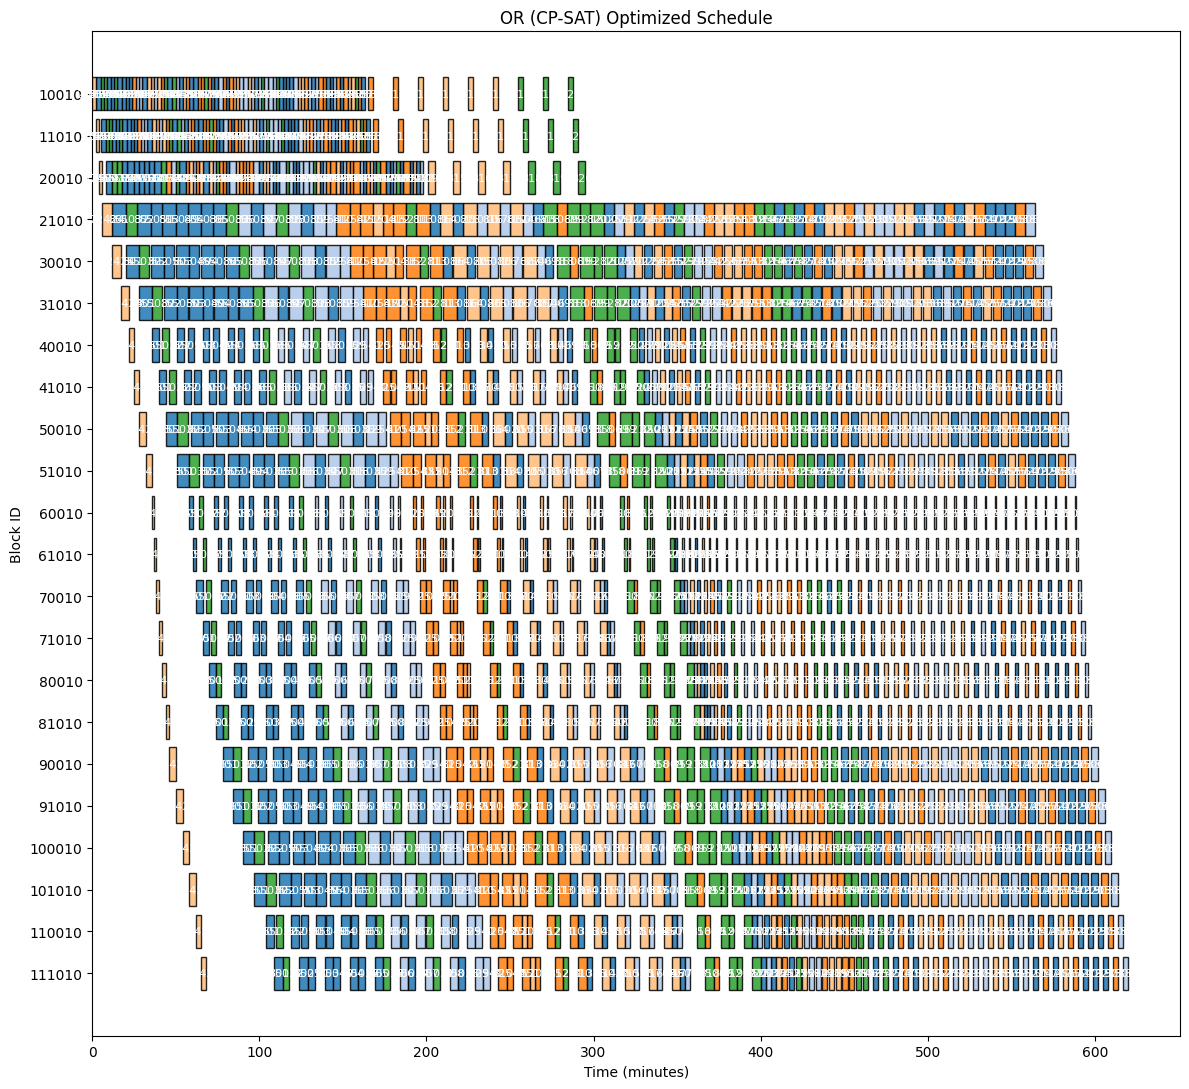

/var/folders/mk/tvz_pqr97_778k6rbbp07ylm0000gn/T/ipykernel_25334/867164514.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", max(1, len(trains)))


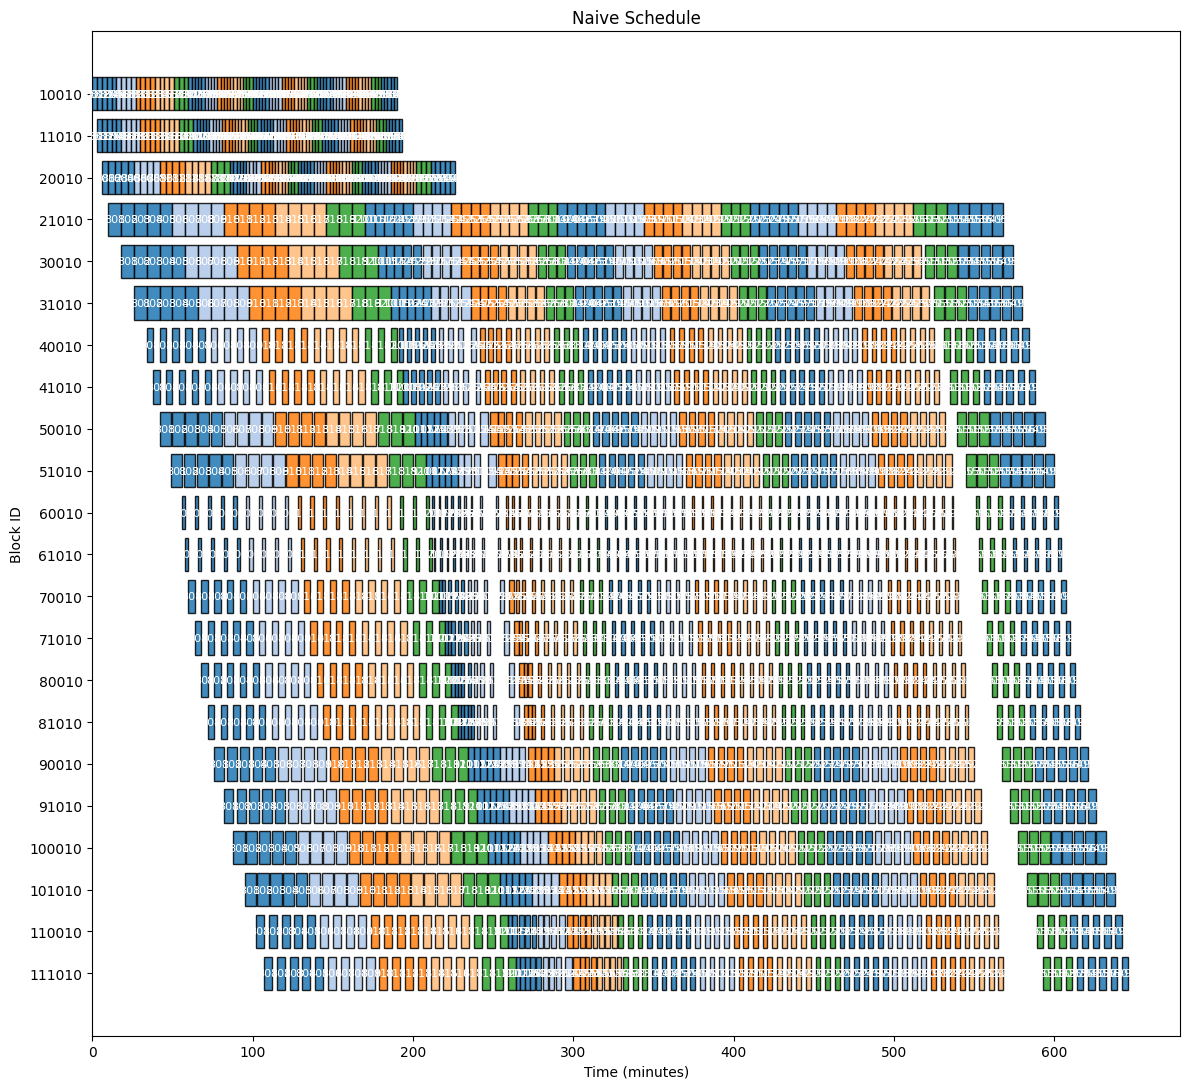

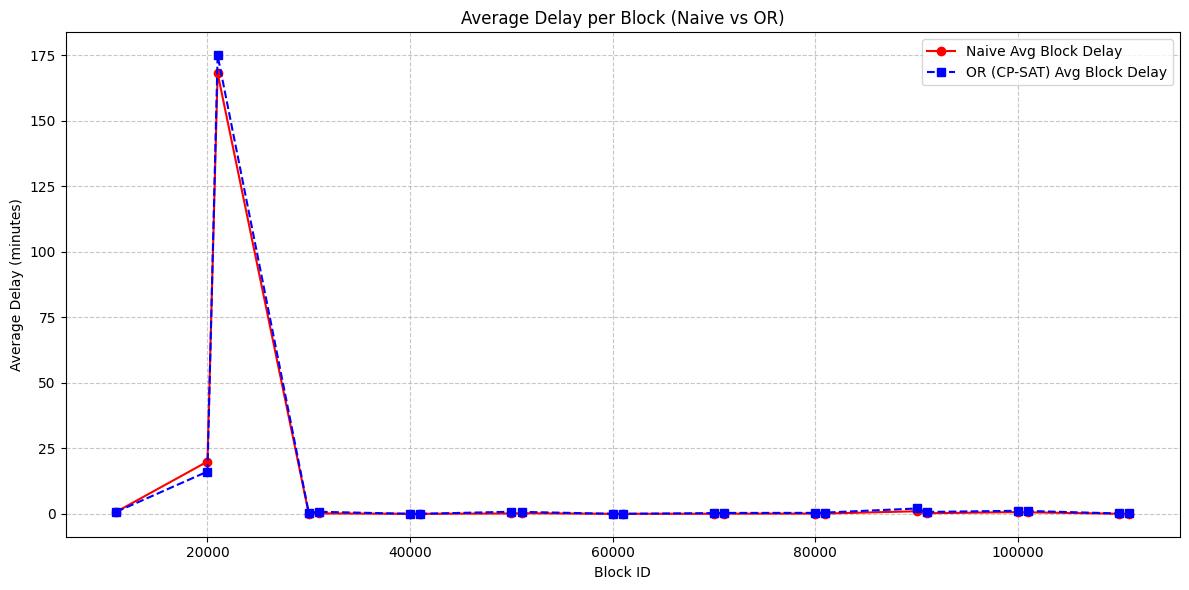

In [22]:
if __name__ == "__main__":
    scheduled_file = "/Users/muskansingh/OR-MILP/or-milp-env/data-folder/scheduled_trains.csv"
    unscheduled_file = "/Users/muskansingh/OR-MILP/or-milp-env/data-folder/unscheduled_trains.csv"
    blocks_file = "/Users/muskansingh/OR-MILP/or-milp-env/data-folder/blocks.csv"
    train_routes = generate_train_routes(blocks_file, scheduled_file, unscheduled_file)
    naive_schedule, or_schedule, naive_metrics, or_metrics = build_and_solve(train_routes, unscheduled_file)
    if or_schedule:
        plot_schedule(or_schedule, "OR (CP-SAT) Optimized Schedule")
    plot_schedule(naive_schedule, "Naive Schedule")

if or_schedule:
    plot_block_delay_linegraph(naive_schedule, or_schedule)

In [23]:
def calculate_throughput(schedule):
    trains_completed = len(set(tid for tid,_,_,_ in schedule)) # Number of unique trains completed
    makespan = max(end for _,_,_,end in schedule) # Makespan = max of end times
    if makespan == 0:
        return 0 
    throughput = trains_completed / makespan
    return throughput
naive_tp = calculate_throughput(naive_schedule)
or_tp = calculate_throughput(or_schedule)

print(f"Naive schedule throughput: {naive_tp:.4f} trains/min")
print(f"OR schedule throughput: {or_tp:.4f} trains/min")

Naive schedule throughput: 0.1316 trains/min
OR schedule throughput: 0.1371 trains/min
